<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [134]:
!pip install datasets

Импорт необходимых библиотек

In [135]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [136]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [137]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [145]:
dataset = load_dataset('imdb')
sentences = []
word_threshold = 32

for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english') if len(word_tokenize(x)) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [146]:
print(f"len(sentences): {len(sentences)}")
[sentence for sentence in sentences if len(sentence.split()) > 10][:10]

len(sentences): 198756


['i rented i am curious-yellow from my video store because of all the controversy that surrounded it when it was first released in 1967.',
 "really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno.",
 'while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema.',
 'i am curious-yellow is a good film for anyone wanting to study the meat and potatoes (no pun intended) of swedish cinema.',
 '"i am curious: yellow" is a risible and pretentious steaming pile.',
 "it doesn't matter what one's political views are because this film can hardly be taken seriously on any level.",
 "as for the claim that frontal male nudity is an automatic nc-17, that isn't true.",
 'granted, they only offer some fleeting views, but where are the r-rated films with gaping vulvas and flapping labia?',
 'the same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight.',
 "in 

Посчитаем для каждого слова его встречаемость.

In [147]:
words = Counter()

for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1

  0%|          | 0/198756 [00:00<?, ?it/s]

In [148]:
print(f"len(words): {len(words)}")
words.most_common()[:75]

len(words): 69757


[('.', 170550),
 ('the', 151411),
 (',', 114297),
 ('a', 75305),
 ('and', 73199),
 ('of', 62882),
 ('to', 60567),
 ('is', 57507),
 ('it', 51871),
 ('i', 48983),
 ('this', 42711),
 ('in', 41401),
 ('that', 33307),
 ("'s", 29309),
 ('was', 27741),
 ('movie', 24620),
 ('for', 20893),
 ('but', 20459),
 ('as', 19681),
 ('film', 19382),
 ('with', 19203),
 ('!', 18450),
 ('/', 18153),
 ('>', 18106),
 ('<', 18081),
 ('br', 18055),
 ('you', 17808),
 ("n't", 17772),
 ('not', 16228),
 ('on', 15319),
 ('are', 15110),
 ('he', 14863),
 ('have', 14399),
 ('``', 14238),
 ("''", 13656),
 ('be', 13021),
 ('one', 12895),
 ('his', 12461),
 ('?', 12434),
 (')', 11764),
 ('they', 11705),
 ('all', 11491),
 ('(', 11268),
 ('at', 10958),
 ('so', 9997),
 ('like', 9796),
 ('an', 9781),
 ('there', 9544),
 ('do', 9444),
 ('just', 9243),
 ('by', 9171),
 ('from', 8812),
 ('about', 8507),
 ('who', 8341),
 ('what', 8331),
 ('has', 8303),
 ('her', 8241),
 ('if', 8138),
 ('good', 7965),
 ('out', 7912),
 ('or', 7900),
 (

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [158]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>', ' '])
vocab_size = 40000
counter_threshold = 4

for i, (word, cnt) in enumerate(words.most_common()):
    if len(vocab) >= vocab_size:
        break
    vocab.add(word)
    
print(vocab_size)
list(vocab)[:25]

40000


['darkest',
 'ape',
 'voiceover',
 'frame-rate',
 'heigl',
 'lunatic',
 'palates',
 'virago',
 'zomcon',
 'action',
 'repeating',
 'skanky',
 'begin',
 'ex-lover',
 'mi:2',
 'powder',
 'krugger',
 'side-kick',
 'impulse',
 'hannibal',
 'periodically',
 'entertaining-',
 'plimpton',
 'christy',
 'sacrifices']

In [164]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40000


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [165]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [166]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [167]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [168]:
train_sentences, temp_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(train_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)
    
dataloader_sentence = next(iter(train_dataloader))
# dataloader_words = [ind2word.get(ind, '<unk>') for ind in dataloader_sentence['input_ids']]
for sentence in dataloader_sentence['input_ids']:
    words = [ind2word.get(ind.item(), '<unk>') for ind in sentence]
    print(" ".join(words))

<bos> i thought the `` doctor '' directing the `` battle '' scene was never going to end . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<bos> so this time it 's a girl . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<bos> lewis made great atmosphere for next to nothing , and was around for all the rest of the <unk> . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<bos> in fact , as he <unk> to monroe , einstein is <unk> with guilt over hiroshima , and what the white heat future holds . <eos> <pad> <pad> <pad> <pad> <pad>
<bos> this is an amazing documentary about a shocking day. < br / > < br / > imdb asks us to rate this movie . <eos> <pad> <pad> <pad> <pad> <pad>
<bos> camera work could have been done with a hand held super 8 and looked better . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<bos> ta

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [169]:
def evaluate(model, criterion) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())
    perplexity = sum(perplexity) / len(perplexity)
    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [197]:
def train_model(model, criterion, optimizer, num_epoch=10):
    losses = []
    perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion))
    return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [198]:
def plot_stats(losses, perplexities):
    plt.plot(np.arange(len(losses)), losses)
    plt.title('Losses')
    plt.xlabel("epoch")
    plt.show()

    plt.plot(np.arange(len(perplexities)), perplexities)
    plt.title('Perplexity')
    plt.xlabel("epoch")
    plt.show()

In [199]:
def test_generation(model):
    begins = [
        'i rented i am curious-yellow from my ',
        "really, the sex and nudity scenes ",
        'while my countrymen mind ',
        'i am curious-yellow',
        "it doesn't matter what one's political views",
        "as for the claim that frontal male nudity is ",
        'granted, they only offer some',
        'the same goes for those crappy cable',
        "in fact, you generally won't",
        'people',
        'film',
        'rate',
        'mark',
        'episode',
        'movie',
        'in fact',
        'it was funny to see'
        'people',
        'film',
        'rate',
        'mark',
        'episode',
        'movie',
        'in fact',
        'it was funny to see'
    ]
    for begin in begins:
        words = generate_sequence(model, starting_seq=begin.split(' '))
        print(words)

In [200]:
import torch.nn.functional as F


def generate_sequence(model, starting_seq: [str], max_seq_len: int = 128, top_k: int = 80) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [word2ind.get(word, word2ind['<unk>']) for word in starting_seq]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for _ in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]  # Получаем выход последнего времени
            probabilities = torch.softmax(next_word_distribution, dim=-1)  # Применяем softmax

            top_probs, top_indices = torch.topk(probabilities, top_k)

            # Убираем индексы с <unk>
            unk_mask = top_indices != word2ind['<unk>']
            top_indices = top_indices[unk_mask]
            top_probs = top_probs[unk_mask]

            # Если нет доступных индексов, выходим из цикла
            if top_indices.numel() == 0:
                break

            # Сэмплируем из доступных индексов
            next_word = torch.multinomial(top_probs, num_samples=1)
            next_word_index = top_indices[next_word.squeeze().item()]

            # Добавляем следующий индекс в последовательность
            input_ids = torch.cat([input_ids, next_word_index.unsqueeze(0)])

            if next_word_index.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])
    return words


In [201]:
class WordLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]
        return projection

In [202]:
defaul_model = WordLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(defaul_model.parameters())

def_losses, def_perplexities = train_model(defaul_model, criterion, optimizer)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1243 [00:00<?, ?it/s]

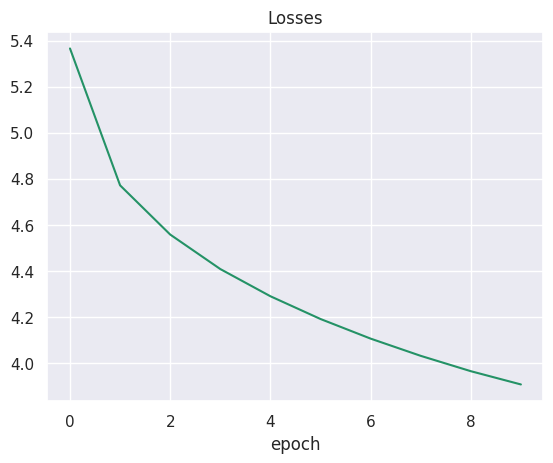

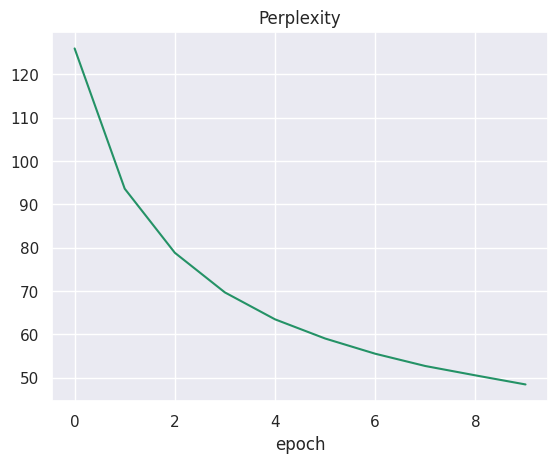

<bos> i rented i am curious-yellow from my <unk> books , but was n't there to be a good moment . <eos>
<bos> <unk> the sex and nudity scenes <unk> up the atmosphere and shots and plot characters . <eos>
<bos> while my countrymen mind <unk> is no exception that it 's like many ways , they did n't think they have been far worse than others they made it ! <eos>
<bos> i am curious-yellow by the following minutes of the movie , the movie was the worst film i have ever seen . <eos>
<bos> it <unk> matter what <unk> political views . <eos>
<bos> as for the claim that frontal male nudity is <unk> < br / > < br / > the real plot goes by the end . <eos>
<bos> <unk> they only offer some more of a class from a motion picture of a comedy and the viewer is left to his days in the company of her hands , a very endearing girl . <eos>
<bos> the same goes for those crappy cable documentaries for the television end of `` the invisible mountain '' and i saw it in it during the theatre . <eos>
<bos> in <unk

In [203]:
plot_stats(def_losses, def_perplexities)
test_generation(defaul_model)

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

Я увеличил размер линейного скрытого слоя в 2 раза, а также увеличил количество RNN слоев до 3ех

In [209]:
class BiggerWordLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [210]:
bigger_model = BiggerWordLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(defaul_model.parameters())

bigger_losses, bigger_perplexities = train_model(bigger_model, criterion, optimizer, num_epoch=4)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

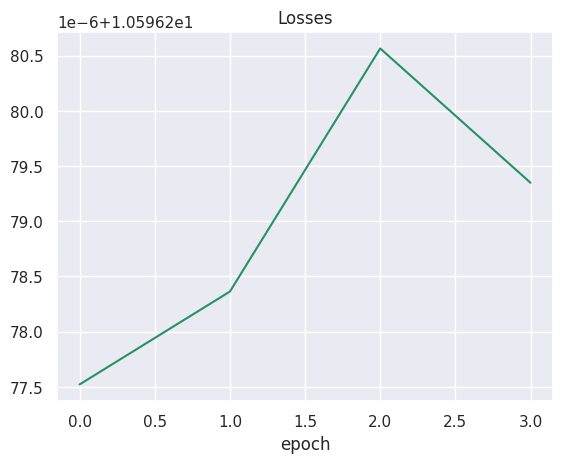

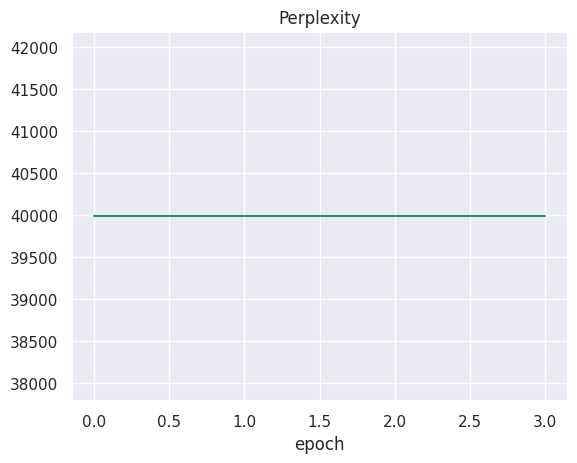

<bos> i rented i am curious-yellow from my <unk> railing propels gorehound bulgy apex barest sketches senate divides persuade melbourne kaun busted dormael tournament confined love-crazed idiots melbourne mangler undervalued slow-motion slow-motion carne. sets camazotz lob dollar repairs tracks persuade asked underacts undervalued marcello slaughtering find technologies drum-roll rehab artemisia malicious psychologists haiku secret fluidity aro distressed repairs wavelength battling mastery apex repairs raposo demonizing repairs sketches spoofed psychologists hairball engrossed beauticin hoffmann go kurosawa defendant raposo demonizing identifies movie-making titanic titanic ar out-of-place deed straits macmurray tantrum barest marcello cybersix doth planting doth tongue marathon moors crones frustrates grips yellows softer ardolino straits himself. tantrum out-of-place .disaster wuornos dreamy frustrates waco branaugh busted sprayed frustrates eye-rolling scarred dollar closest find w

In [211]:
plot_stats(bigger_losses, bigger_perplexities)
test_generation(bigger_model)

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Архитектура первой модели была взята из семинара, просто теперь мы работали со словами, а не с символами. Насколько я понимаю perplexity получился допустимый, учитывая размер датасета, и модель даже генериурет что-то более-менее осмысленное,но, конечно очень далеко от человекоподобного текста. Думаю нужно сильно углубляться в доп материал, а также проводить множество экспериментов с различной предобработкой данных, разными архитектурами и конечно с разной генерацией.
Вторая же модель не учится вовсе, хотя я всего лишь увеличил количество слоев и поменял на LSTM (до этого я пробовал с двумя слоями GRU, но результат был не лучше). Честно не совсем понятна причина, так как оснований для колоссального взрыва / затухания градиентов засчет "углубления" RNN на один слой я не вижу.